In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
- Pega o diretório do dataset até o número da sequência
- Procura pelo subdiretório velodyne para retirar o .bin do frame
- Transforma os dados do .bin em uma matriz bidimensional
- Pega cada ponto do .bin e concatena a uma lista e retorna
'''

def load_semantic_kitti_data(sequence_path, frame_number):
    point_cloud = []
    
    velodyne_path = os.path.join(sequence_path, 'velodyne')

    file_name = f"{frame_number:06d}.bin"
    file_path = os.path.join(velodyne_path, file_name)

    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            points = np.fromfile(f, dtype=np.float32).reshape(-1, 4)

            coordinates = points[:, :4]

            point_cloud.append(coordinates)
    else:
        print(f"Arquivo {file_name} não encontrado no diretório 'velodyne' da sequência.")
    if not point_cloud:
        print("Nenhum dado encontrado para o frame especificado.")
        
    point_cloud = np.concatenate(point_cloud, axis=0)

    return point_cloud

In [3]:
'''
- Pega o diretório do dataset até o número da sequência
- Procura pelo subdiretório labels para retirar o .label do frame
- Transforma os dados do .label em uma matriz bidimensional
- Pega cada ponto do .label e adiciona a uma lista e retorna
'''
def load_semantic_kitti_label(sequence_path, frame_number):
    labels = []

    label_path = os.path.join(sequence_path, 'labels')

    file_name = f"{frame_number:06d}.label"
    file_path = os.path.join(label_path, file_name)
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            point_labels = np.fromfile(f, dtype=np.uint32).reshape((-1))

            # O semanticKitti faz as labels serem separadas por bits
            point_labels = point_labels & 0xFFFF

            labels.append(point_labels)
    else:
        print(f"Arquivo {file_name} não encontrado no diretório 'labels'da sequência.")
    if not labels:
        print("Nenhum dado encontrado para o frame especificado.")
    
    labels = np.array(labels)
    
    return labels

In [4]:
'''
- Dicionário das cores correspondentes às labels
'''
color_map = {
    0: [0, 0, 0],
    1: [255, 0, 0],
    10: [100, 150, 245],
    11: [100, 230, 245],
    13: [100, 80, 250],
    15: [30, 60, 150],
    16: [0, 0, 255],
    18: [80, 30, 180],
    20: [0, 0, 255],
    30: [255, 30, 30],
    31: [255, 40, 200],
    32: [150, 30, 90],
    40: [255, 0, 255],
    44: [255, 150, 255],
    48: [75, 0, 75],
    49: [175, 0, 75],
    50: [255, 200, 0],
    51: [255, 120, 50],
    52: [255, 150, 0],
    60: [150, 255, 170],
    70: [0, 175, 0],
    71: [135, 60, 0],
    72: [150, 240, 80],
    80: [255, 240, 150],
    81: [255, 0, 0],
    99: [50, 255, 255],
    252: [100, 150, 245],
    256: [0, 0, 255],
    253: [255, 40, 200],
    254: [255, 30, 30],
    255: [150, 30, 90],
    257: [100, 80, 250],
    258: [80, 30, 180],
    259: [0, 0, 255]
}

In [5]:
'''
- O shape da matriz de labels vem [1, pontos_da_nuvem]
- É preciso transpor para juntar a coluna de labels com a matriz .bin
'''
def concatenate_cloud_with_label(point_cloud, labels):
    
    labels_T = labels.T
    labeled_cloud = np.concatenate((point_cloud, labels_T), axis=1)

    return labeled_cloud

In [6]:
'''
- Para a projeção esférica são lidos as coordenadas x,y,z de cada ponto
- R é a distância do laser até a origem (LiDAR)
- desvio_eixoY é o valor no plano xy e o ângulo com range de [FOV_UP, FOV_DOWN] para max/min
- desvio_eixoX é o valor no plano xz com range de [-pi,pi] por causa da função arctan2
- É necessário negar arctan2 para evitar espelhamento
- É necessário normalizar os desvios para pegar os pontos na distorção para 2D
- Como o modelo do LiDAR utilizado é o Velodyne HDL 64-E, a imagem deve ser 64x1024
- Retorna o ponto (normal_Y,normal_X, intensidade, label) da projeção
'''

def spherical_projection(point_cloud):
    x_coord = point_cloud[:, 0]
    y_coord = point_cloud[:, 1]
    z_coord = point_cloud[:, 2]

    R = np.sqrt(x_coord**2 + y_coord**2 + z_coord**2)

    desvio_eixoY = np.arcsin(z_coord/R)
    desvio_eixoX = -np.arctan2(y_coord, x_coord)

    FOV_UP = np.max(desvio_eixoY)
    FOV_DOWN = np.min(desvio_eixoY)
    FOV = FOV_UP + abs(FOV_DOWN)

    normal_Y = 1.0 - ((desvio_eixoY + abs(FOV_DOWN))/FOV)
    normal_X = 0.5 * (desvio_eixoX/np.pi + 1)

    
    return normal_Y*64, normal_X*1024, point_cloud[:, 3], point_cloud[:, 4]


In [7]:
'''
- A imagem é formada no plano zy
- É necessário truncar os valores para servirem como índice na matriz
- Retorna a matriz com índices da itensidade e com as keys da label
'''
def create_ImageMatrix(normal_Y, normal_X, intensity, label):
    truncated_Y = np.minimum(63, np.round(normal_Y))
    index_Y = np.maximum(0, truncated_Y).astype(int)
    
    truncated_X = np.minimum(1023, np.round(normal_X))
    index_X = np.maximum(0, truncated_X).astype(int)
    
    image_matrix_no_label = np.zeros((64, 1024))
    image_matrix_with_label = np.zeros((64, 1024))
    
    for x, y, i in zip(index_X, index_Y, intensity):
        image_matrix_no_label[y, x] = i
    
    for x, y, i in zip(index_X, index_Y, label):
        image_matrix_with_label[y, x] = i
        
    return image_matrix_no_label, image_matrix_with_label

In [8]:
'''
- Substitui as keys da matriz de label pela respectiva cor do dicionário color_map
- Retorna a matriz de label no formato (64, 1024, 3)
'''
def colored_matrix_with_label(image_matrix_with_label):
    
    colored_matrix =  np.empty(image_matrix_with_label.shape + (3,), dtype=np.uint8)
    
    for key, value in color_map.items():
        indices = np.where(image_matrix_with_label == key)
        colored_matrix[indices] = value
    
    image_matrix_with_label = colored_matrix

    return image_matrix_with_label

In [9]:
'''
- Projeta a imagem sem label e com label
- Salva um png para melhor visualização
- Note que a dimensão do png não é a da matriz
'''
def visualize_spherical_projection(not_labeled_matrix, labeled_matrix):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    
    # Plote a primeira matriz no primeiro subplot
    axes[0].imshow(not_labeled_matrix, cmap='jet')
    axes[0].set_title('2D Not Labeled Spherical Projection')

    # Plote a segunda matriz no segundo subplot
    axes[1].imshow(labeled_matrix, cmap='jet')
    axes[1].set_title('2D Labeled Spherical Projection')
    
    
    plt.savefig("Projeção_Esférica_2D_Comparação.png", dpi=1200)
    
    # Ajuste o layout para evitar sobreposição
    plt.tight_layout()

    plt.show()
    

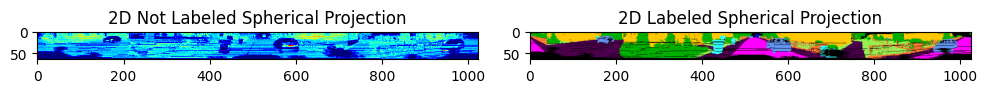

In [10]:
# Caminho para o diretório do dataset SemanticKITTI
sequence_path = 'A:/SemanticKITTI/dataset/sequences/05/'
# Número do frame desejado
frame_number = 300

# Carrega os dados do dataset
point_cloud = load_semantic_kitti_data(sequence_path, frame_number)
labels = load_semantic_kitti_label(sequence_path, frame_number)

# Concatena a nuvem com os rotulos para máscara semântica
labeled_cloud = concatenate_cloud_with_label(point_cloud, labels)

# Projeção esférica dos pontos da nuvem
rows, cols, intensity, label = spherical_projection(labeled_cloud)

# Criação da imagem (matriz)
image_matrix_no_label, image_matrix_with_label = create_ImageMatrix(rows, cols, intensity, label)

# Coloração da matriz de labels
image_matrix_with_label = colored_matrix_with_label(image_matrix_with_label)

# Visualização da projeção
visualize_spherical_projection(image_matrix_no_label, image_matrix_with_label)